# Parameter Inference

This is a script for running parameter inference for a RC model based on given measurement data. 
The main purposes are:
1. enable differentiable parameter inference based on differential programming
2. check if GPU can be faster than CPU application
    - on my local machine, GPU run time is thousand time slower than CPU
    - need run more tests on Google Colab
        - single GPU
        - multiple TPUs

In [1]:
from jax.tools import colab_tpu
colab_tpu.setup_tpu()

In [2]:
!pip install diffrax optax
import os
# Limit ourselves to single-threaded jax/xla operations to avoid thrashing. See
# https://github.com/google/jax/issues/743.
#os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false "
#                           "intra_op_parallelism_threads=1")

import jax
import jax.numpy as jnp
import pandas as pd 
import numpy as np
from jax import jit, lax, config
from jax import grad
from diffrax import diffeqsolve, ODETerm, Euler, Dopri5, SaveAt, PIDController
import optax 
import matplotlib.pyplot as plt
import time 
import json
from functools import partial 

# The following is required to use TPU Driver as JAX's backend.
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 4.8 MB/s 
     |████████████████████████████████| 154 kB 30.1 MB/s 
     |████████████████████████████████| 88 kB 8.1 MB/s 
     |████████████████████████████████| 85 kB 4.7 MB/s 
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [3]:
n_devices = jax.local_device_count()
print(n_devices) 
print(jax.devices())

8
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


This is a 4r3c model for zone temperature prediction
```
ODE::   xdot = Ax + Bd
        y = Cx
States:
        x = [Tai, Twe, Twi]'
Disturbances:
        u = [Tao, qCon_i, qHVAC, qRad_e, qRad_i]'
Output:
        y = [Tai]

```

In [4]:
@jit
def get_ABCD(Cai, Cwe, Cwi, Re, Ri, Rw, Rg):
    A = jnp.zeros((3, 3))
    B = jnp.zeros((3, 5))
    C = jnp.zeros((1, 3))
    A = A.at[0, 0].set(-1/Cai*(1/Rg+1/Ri))
    A = A.at[0, 2].set(1/(Cai*Ri))
    A = A.at[1, 1].set(-1/Cwe*(1/Re+1/Rw))
    A = A.at[1, 2].set(1/(Cwe*Rw))
    A = A.at[2, 0].set(1/(Cwi*Ri))
    A = A.at[2, 1].set(1/(Cwi*Rw))
    A = A.at[2, 2].set(-1/Cwi*(1/Rw+1/Ri))

    B = B.at[0, 0].set(1/(Cai*Rg))
    B = B.at[0, 1].set(1/Cai)
    B = B.at[0, 2].set(1/Cai)
    B = B.at[1, 0].set(1/(Cwe*Re))
    B = B.at[1, 3].set(1/Cwe)
    B = B.at[2, 4].set(1/Cwi)

    C = C.at[0, 0].set(1)

    D = 0

    return A, B, C, D

@jit
def zone_state_space(t, x, A, B, d):
    x = x.reshape(-1, 1)
    d = d.reshape(-1, 1)
    dx = jnp.matmul(A, x) + jnp.matmul(B, d)
    dx = dx.reshape(-1)

    return dx

## Forward Simulation


In [5]:
@partial(jit, static_argnums=(0, 1, 2, 3,))
def forward(func, ts, te, dt, x0, solver, args):
    # unpack args
    A, B, d = args

    # ode formulation
    term = ODETerm(func)

    # initial step
    t = ts
    tnext = t + dt
    dprev = d[0, :]
    args = (A, B, dprev)
    state = solver.init(term, t, tnext, x0, args)

    # initialize output
    #t_all = [t]
    #x_all = [x0]

    # main loop
    i = 0
    #x = x0

    # jit-ed scan to replace while loop
#    cond_func = lambda t: t < te
    def step_at_t(carryover, t, term, dt, te, A, B, d):
        # the lax.scannable function to computer ODE/DAE systems
        x = carryover[0]
        state = carryover[1]
        i = carryover[2]
        args = (A, B, d[i, :])
        tnext = jnp.minimum(t + dt, te)

        xnext, _, _, state, _ = solver.step(
            term, t, tnext, x, args, state, made_jump=False)
        i += 1

        return (xnext, state, i), x

    carryover_init = (x0, state, i)
    step_func = partial(step_at_t, term=term, dt=dt, te=te, A=A, B=B, d=d)
    time_steps = np.arange(ts, te+1, dt)
    carryover_final, x_all = lax.scan(
        step_func, init=carryover_init, xs=time_steps)

    return time_steps, x_all

## Inference

### Load Data

In [6]:
# load training data - 1-min sampling rate
data = pd.read_csv('/home/disturbance_1min.csv', index_col=[0])
index = range(0, len(data)*60, 60)
data.index = index

# sample every hour
dt = 3600
data = data.groupby([data.index // dt]).mean()
n = len(data)

# split training and testing
ratio = 0.75
n_train = int(len(data)*ratio)
print(n_train)
data_train = data.iloc[:n_train, :]
data_test = data.iloc[n_train:, :]

# define training parameters 
ts = 0
te = ts + n_train*dt
solver = Euler()


504


### Model


In [7]:
# forward steps
f = lambda t, x, args: zone_state_space(t, x, *args)#args[0], args[1], args[2]) 
def forward_parameters(p, x, ts, te, dt, solver, d):
    """
    p is [Cai, Cwe, Cwi, Re, Ri, Rw, Rg, Twe0, Twi0]
    x is Tz0
    """
    Cai, Cwe, Cwi, Re, Ri, Rw, Rg, Twe0, Twi0 = p['rc']
    A, B, C, D = get_ABCD(Cai, Cwe, Cwi, Re, Ri, Rw, Rg)
    args = (A, B, d)

    # intial point
    x0 = jnp.array([x, Twe0, Twi0])

    # forward calculation
    t, x = forward(f, ts, te, dt, x0, solver, args)

    return t, x 

model = lambda p,x: forward_parameters(p, x, ts, te, dt, solver, d)
model = jit(model)

### Loss Function

In [8]:
# loss function
@jit
def loss_fcn(p, x, y_true, p_lb, p_ub):
    _, y_pred = model(p, x)
    loss = jnp.mean((y_pred[1:,0] - y_true)**2)

    penalty = jnp.sum(jax.nn.relu(p['rc'] - p_ub) + jax.nn.relu(p_lb - p['rc']))

    return loss + penalty


### Data Preparation

In [9]:
d = data_train.values[:,:5]
y_train = data_train.values[:,5]
d = jax.device_put(d)
y_train=jax.device_put(y_train)


### Training 

In [10]:

def fit(data, n_epochs, params: optax.Params, optimizer: optax.GradientTransformation, p_lb, p_ub) -> optax.Params:
    # initialize params
    states = optimizer.init(params)
    x, y = data 

    """
    @jit
    def step(params, states, x, y, p_lb, p_ub):
        loss, grads = jax.value_and_grad(loss_fcn)(params, x, y, p_lb, p_ub)
        updates, states = optimizer.update(grads, states, params)
        params = optax.apply_updates(params, updates)

        return params, states, loss, grads
    
    for epoch in range(n_epochs):
        params, states, loss, grads = step(params, states, x, y, p_lb, p_ub)
        if epoch % 1000 == 0:
            print(f'epoch {epoch}, training loss: {loss}')
            #print(grads['rc'].max(), grads['rc'].min())
    """  
    # scanned step function
    def step_for_scan(carry, epoch, x, y, p_lb, p_ub):
        params, states = carry
        loss, grads = jax.value_and_grad(loss_fcn)(params, x, y, p_lb, p_ub)
        updates, states = optimizer.update(grads, states, params)
        params = optax.apply_updates(params, updates)

        return (params, states), loss

    # scan in jax
    step_func = partial(step_for_scan, x=x, y=y, p_lb=p_lb, p_ub=p_ub)
    
    # initials
    carry_init = (params, states)
    steps = jnp.arange(0, n_epochs, 1)
    
    # for loop training
    carry_final, losses = lax.scan(
        step_func, init=carry_init, xs=steps)
    
    # get results
    params, states = carry_final

    return params, losses

## Run optimization for inference
# parameter settings
p_lb = jnp.array([1.0E3, 1.0E4, 1.0E5, 1.0, 1E-02, 1.0, 1.0E-1, 20.0, 20.0])
p_ub = jnp.array([1.0E5, 1.0E6, 1.0E7, 10., 10., 100., 10., 35.0, 30.0])

#p0 = jnp.array([9998.0869140625, 99998.0859375, 999999.5625, 9.94130802154541, 0.6232420802116394, 1.1442776918411255, 5.741048812866211, 34.82638931274414, 26.184139251708984])

p0 = p_ub
x0 = jax.device_put(y_train[0])
print(p0, x0)
print(loss_fcn({'rc':p0}, x0, y_train, p_lb, p_ub))

n_epochs = 100000
schedule = optax.exponential_decay(
    init_value = 0.1, 
    transition_steps = 1000, 
    decay_rate = 0.99, 
    transition_begin=0, 
    staircase=False, 
    end_value=1e-05
)
optimizer = optax.chain(
    optax.adabelief(learning_rate = schedule)
)

initial_params = {'rc': p0}
s = time.time()
params, losses = fit((x0, y_train), n_epochs, initial_params, optimizer, p_lb, p_ub)
e = time.time()  
print(f"execution time is: {e-s} seconds !")

[1.0e+05 1.0e+06 1.0e+07 1.0e+01 1.0e+01 1.0e+02 1.0e+01 3.5e+01 3.0e+01] 23.03648
33.47231
execution time is: 543.7739081382751 seconds !


### Performance Check

single forward simulation costs 0.5294826030731201 s!
(674,) (674,)
(673,)


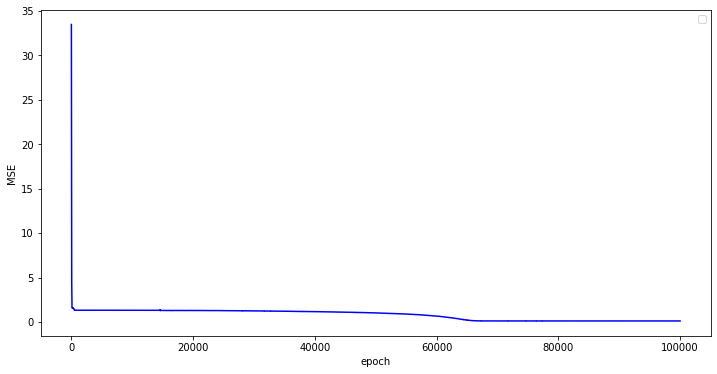

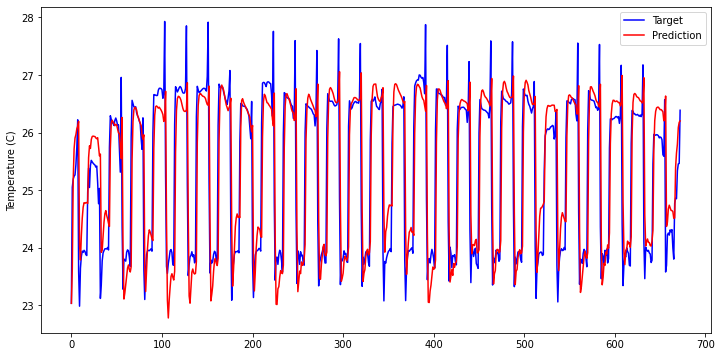

In [11]:
# forward simulation with infered parameters for the whole data set
ts = 0
te = ts + n*dt
d = data.values[:, :5]
y = data.values[:, 5]
forward_ts = time.time()
model = lambda p,x: forward_parameters(p, x, ts, te, dt, solver, d)
t_pred, ys_pred = model(params, x0)
forward_te = time.time()
print(f"single forward simulation costs {forward_te-forward_ts} s!")
y_pred = ys_pred[:,0]

print(t_pred.shape, y_pred.shape) 
print(y.shape)

# plot losses
plt.figure(figsize=(12,6))
plt.plot(losses, 'b-')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.savefig('parameter_inference_losses.png')

# plot inference results
plt.figure(figsize=(12,6))
plt.plot(y, 'b-', label='Target')
plt.plot(y_pred, 'r-', label="Prediction")
plt.ylabel('Temperature (C)')
plt.legend()
plt.savefig('parameter_inference.png')

# save the parameters
params_tolist = [float(p) for p in params['rc']]
with open('zone_coefficients.json', 'w') as f:
    json.dump(params_tolist,f)